# Analyse temporelle et détection d’anomalies sur le marché immobilier
Ce notebook guide l'analyse de la base de transactions immobilières (2018–2022) en mobilisant pandas, NumPy, Matplotlib et Seaborn.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('transactions_immobilires_2018_2022.csv', parse_dates=['transaction_date'])
df.head()

,transaction_date,price
0,2018-01-01,184530.883119
1,2018-01-01,237974.699627
2,2018-01-01,302610.494412
3,2018-01-01,179277.128560
4,2018-01-02,217134.748429


## 1. Préparation des données
**Questions :**
1. Y a-t-il des dates manquantes ou des doublons ?
2. Comment se répartissent les transactions selon le jour de la semaine et le mois ?

**Étapes :**
- Vérification des valeurs manquantes / doublons
- Création des colonnes dérivées (`year`, `month`, `day_of_week`, composants saisonniers)


In [4]:
# 1.1 Vérification des données manquantes et doublons
df.isna().sum()
df.duplicated().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  5412 non-null   datetime64[ns]
 1   price             5412 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 84.7 KB


In [101]:
# 1.2 Création des colonnes dérivées
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df['month+yea'] = df['year'].astype(str).str.cat(df['month'].astype(str), sep ='-')
df['day_of_week'] = df['transaction_date'].dt.day_name()
df['month_sin'] = np.sin(2 * np.pi * (df['month']-1)/12)
df['month_cos'] = np.cos(2 * np.pi * (df['month']-1)/12)
df.head()

,transaction_date,price,year,month,day_of_week,month_sin,month_cos,month+year,month+yea,z_score,outlier_z,outlier_iqr,is_outlier
0,2018-01-01,184530.883119,2018,1,Monday,0.0,1.0,2019,2018-1,-0.363686,False,False,False
1,2018-01-01,237974.699627,2018,1,Monday,0.0,1.0,2019,2018-1,0.868085,False,False,False
2,2018-01-01,302610.494412,2018,1,Monday,0.0,1.0,2019,2018-1,2.357809,False,False,False
3,2018-01-01,179277.128560,2018,1,Monday,0.0,1.0,2019,2018-1,-0.484775,False,False,False
4,2018-01-02,217134.748429,2018,1,Tuesday,0.0,1.0,2019,2018-1,0.387766,False,False,False


## 2. Analyse temporelle
**Questions :**
1. Quelle est la tendance générale du prix moyen annuel ?
2. Existe-t-il une saisonnalité mensuelle marquée ?
3. Comment les moyennes mobiles à 3 et 12 mois lissent-elles ces fluctuations ?

**Étapes :**
- Agrégation mensuelle et annuelle (`resample`, `groupby`)
- Décomposition STL (statsmodels)  (`rolling`)
- Visualisation des séries et boxplots mensuels


In [63]:
""" 2.1 Agrégation mensuelle et annuelle
"""
#monthly=df.groupby('month+yea')['price'].agg(['mean','std','count'])
monthly=df.set_index('transaction_date').resample('ME')['price'].agg(['mean','std','count'])# code à ajouter!!!!!
annual=df.set_index('transaction_date').resample('YE')['price'].agg(['mean','std','count'])
df_groupby_month=df.groupby('month')['price'].agg(['mean','std','count'])
annual.head()

,mean,std,count
transaction_date,,,
2018-12-31,200156.578941,44846.957791,1056
2019-12-31,200953.176281,43186.443518,1076
2020-12-31,201266.270527,43551.276699,1096
2021-12-31,201012.953087,42600.551543,1084
2022-12-31,198184.737037,42766.807301,1100


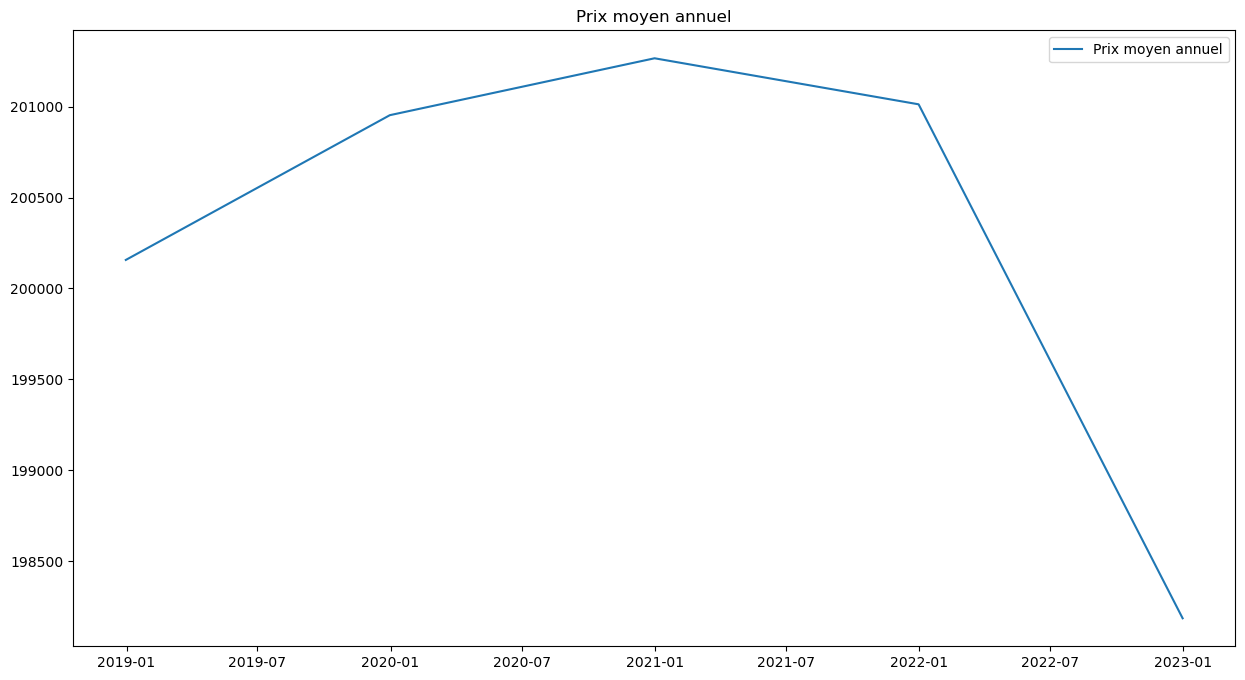

In [61]:
plt.figure(figsize=(15, 8))
plt.plot(annual.index,annual['mean'], label='Prix moyen annuel')
plt.title('Prix moyen annuel')
plt.legend()
plt.show()

In [65]:
monthly.head(), annual.head()
monthly.describe()

,mean,std,count
count,60.000000,60.000000,60.000000
mean,199834.829627,24380.734715,90.200000
std,35924.849906,4135.442736,9.028768
min,144915.384155,17844.782803,71.000000
25%,167985.954984,21618.811100,84.750000
50%,199937.607845,22962.925605,89.000000
75%,231012.087193,26965.848737,95.250000
max,256889.161077,35500.054170,115.000000


In [71]:
# 2.2 Moyennes mobiles
monthly['MA_3']=monthly['mean'].rolling(3).mean()
monthly['MA_12']=monthly['mean'].rolling(12).mean()

In [73]:
monthly.describe()

,mean,std,count,MA_3,MA_12
count,60.000000,60.000000,60.000000,58.000000,49.000000
mean,199834.829627,24380.734715,90.200000,200226.311981,199920.574588
std,35924.849906,4135.442736,9.028768,33102.325893,553.919623
min,144915.384155,17844.782803,71.000000,153024.137679,198657.785630
25%,167985.954984,21618.811100,84.750000,166219.550117,199635.154229
50%,199937.607845,22962.925605,89.000000,199687.210259,199943.791402
75%,231012.087193,26965.848737,95.250000,234349.542201,200267.929355
max,256889.161077,35500.054170,115.000000,248986.579237,201027.869603


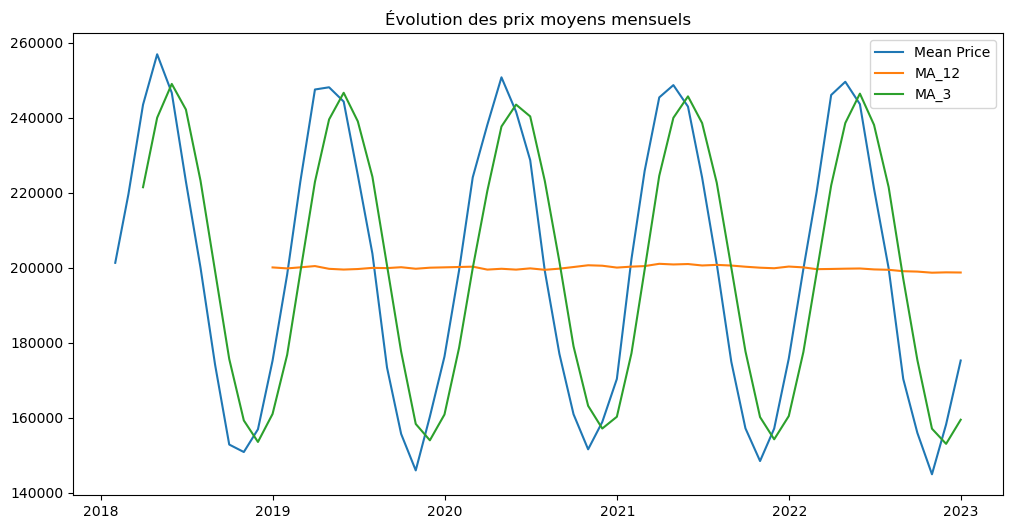

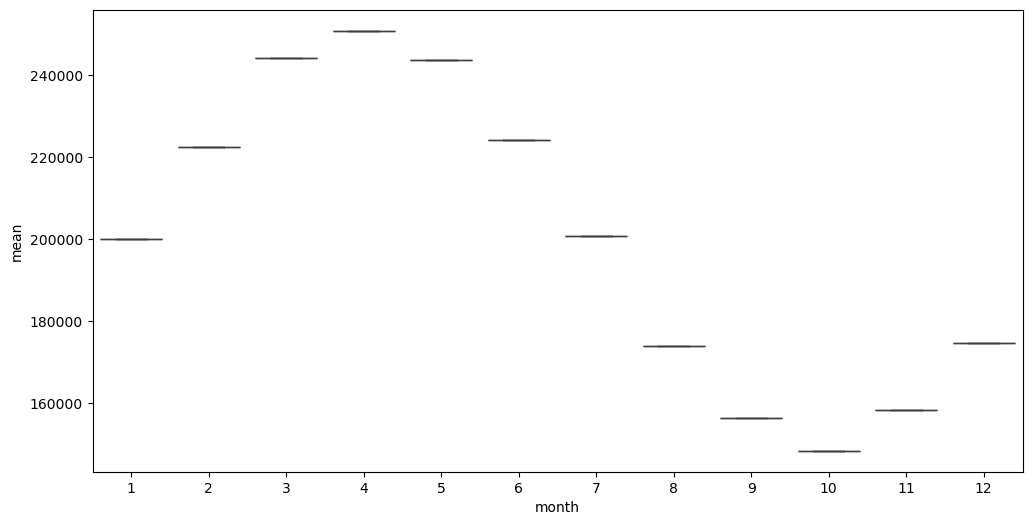

In [109]:
# 2.3 Visualisation
plt.figure(figsize=(12,6))
plt.plot(monthly.index, monthly['mean'], label='Mean Price')
plt.plot(monthly.index, monthly['MA_12'], label='MA_12')
plt.plot(monthly.index, monthly['MA_3'], label='MA_3')
plt.legend()
plt.title('Évolution des prix moyens mensuels')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='mean',data=df_groupby_month)
plt.show()

## 3. Détection d’anomalies
**Questions :**
1. Quels critères (Z-score, IQR) repèrent le mieux les transactions extrêmes ?
2. Quelles catégories (mois, quartile de prix) concentrent le plus d’anomalies ?

**Étapes :**
- Calcul des Z-scores et IQR via NumPy
- Ajout de la colonne `is_outlier`
- Visualisation des anomalies


## Calcul des Z‑scores

### Définition

Le **Z‑score** (ou score standardisé) d’une valeur $x_i$ dans un ensemble de données est le nombre d’écarts‑types ($\sigma$) qu’elle se situe au‑dessus ou en‑dessous de la moyenne ($\mu$) de cet ensemble. Mathématiquement :
$$
Z_i = \frac{x_i - \mu}{\sigma}
$$
- Si $Z_i = 0$, alors $x_i = \mu$.  
- Si $Z_i > 0$, alors $x_i$ est au‑dessus de la moyenne.  
- Si $Z_i < 0$, alors $x_i$ est en‑dessous de la moyenne.  

---

### Interprétation

- Un Z‑score compris entre $-1$ et $+1$ signifie que la valeur est à l’intérieur d’un écart‑type de la moyenne (environ 68 % des données si la distribution est normale).  
- Un Z‑score au‑delà de $\pm 2$ ou $\pm 3$ indique une valeur relativement extrême (outlier) dans une distribution normale théorique.  

---

### Calcul théorique

1. **Calculer la moyenne**

   $$
   \mu = \frac{1}{n} \sum_{i=1}^{n} x_i
   $$

3. **Calculer l’écart‑type**  
   $$
   \sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}
    $$ 
   > *(pour un **échantillon**, on utiliserait $\frac{1}{n-1}$ au dénominateur)*

4. **Appliquer la formule du Z‑score**  
   Pour chaque $x_i$ :
   $$
   Z_i = \frac{x_i - \mu}{\sigma}
   $$

---

## Calcul de l’Interquartile Range (IQR)

### Définition

L’**Interquartile Range** (IQR) mesure l’étendue du milieu de la distribution :

$$
\mathrm{IQR} = Q_3 - Q_1
$$

où :

- $Q_1$ est le premier quartile (valeur sous laquelle se trouvent 25 % des observations).  
- $Q_3$ est le troisième quartile (valeur sous laquelle se trouvent 75 % des observations).  

---

### Interprétation

- L’IQR représente la dispersion “centrale” des données, moins sensible aux valeurs extrêmes que l’écart‑type.  
- On définit parfois comme **outliers** les points $x_i$ tels que :  
  $$
  x_i < Q_1 - 1.5 \times \mathrm{IQR}
  \quad\text{ou}\quad
  x_i > Q_3 + 1.5 \times \mathrm{IQR}
  $$

---

### Calcul théorique

1. **Trier les données** en ordre croissant.  
2. **Déterminer la position de $Q_1$**  
   $$
   \text{indice}_{Q_1} = \frac{n + 1}{4}
    $$ 
   et interpoler si nécessaire.  
3. **Déterminer la position de $Q_3$**  
  $$ 
   \text{indice}_{Q_3} = \frac{3 \times (n + 1)}{4}
    $$ 
   et interpoler si nécessaire.  
4. **Calculer l’IQR**  
  $$ 
   \mathrm{IQR} = Q_3 - Q_1
   $$


In [103]:
# 3.1 Z-score
# code à ajouter!!!!!
prix_mean=df['price'].mean()
prix_std=df['price'].std()
df['z_score']= (df['price']-prix_mean)/prix_std
df['outlier_z'] = df['z_score'].abs() > 3
df.head()

# 3.2 IQR
# code à ajouter!!!!!

q1= df['price'].quantile(0.25)
q3= df['price'].quantile(0.75)
iqr=q3-q1
df['outlier_iqr']= (df['price']<q1 -1.5*iqr)| (df['price']> q3 + 1.5*iqr)

df['is_outlier']= df['outlier_iqr'] | df['outlier_z']

df.head()

,transaction_date,price,year,month,day_of_week,month_sin,month_cos,month+year,month+yea,z_score,outlier_z,outlier_iqr,is_outlier
0,2018-01-01,184530.883119,2018,1,Monday,0.0,1.0,2019,2018-1,-0.363686,False,False,False
1,2018-01-01,237974.699627,2018,1,Monday,0.0,1.0,2019,2018-1,0.868085,False,False,False
2,2018-01-01,302610.494412,2018,1,Monday,0.0,1.0,2019,2018-1,2.357809,False,False,False
3,2018-01-01,179277.128560,2018,1,Monday,0.0,1.0,2019,2018-1,-0.484775,False,False,False
4,2018-01-02,217134.748429,2018,1,Tuesday,0.0,1.0,2019,2018-1,0.387766,False,False,False


## 4. Visualisations principales
**Questions :**
1. Comment la distribution des prix évolue-t-elle selon le mois ?
2. Les anomalies sont-elles corrélées à la saison ou au volume de transactions ?

**Étapes :**
- Boxplots mensuels et violin + swarm
- Scatter temps vs prix coloré par anomalie


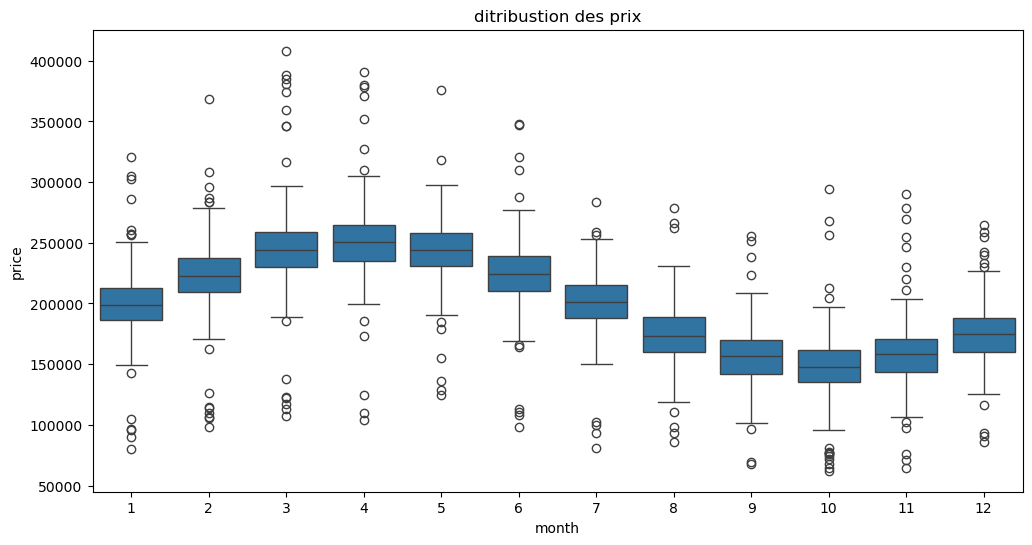

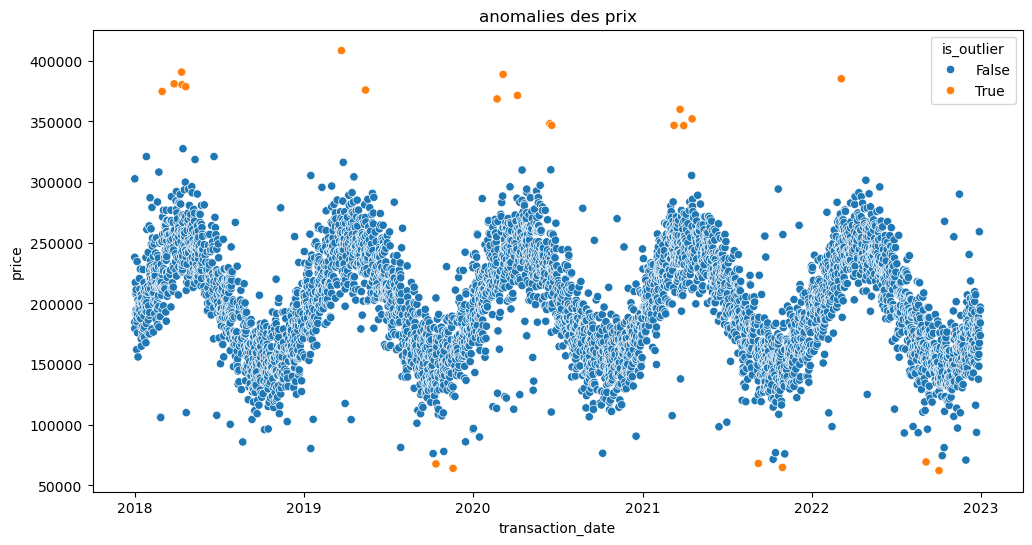

In [107]:
# Boxplot mensuel
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='price',data=df)
plt.title("ditribustion des prix")
plt.show()


# Scatter plot anomalies
plt.figure(figsize=(12,6))
sns.scatterplot(x='transaction_date', y='price',data=df, hue='is_outlier')
plt.title("anomalies des prix")
plt.show()


## 5. Synthèse et reporting
**Questions :**
1. Quels sont les enseignements clés à retenir ?
2. Quelles recommandations formulez-vous pour les acteurs du marché ?

**Étapes :**
- Rédiger un résumé
